# Tensor Methods Homework 5

In this assignment, we consider the following functions $f$ and $g$ defined pointwise on $[−1, 1]^d$ with $d \in \mathbb{N}$ as follows:
$$ f(x_1, \dots, x_d) = \left( 1 + \sum_{k=1}^d \frac{x_k^2}{8^{k-1}} \right)^{-1} $$
and
$$ g(x_1, \dots, x_d) = \sqrt{\sum_{k=1}^d \frac{x_k^2}{8^{k-1}}} \cdot \left( 1 + \frac{1}{2} \cos \sum_{k=1}^d \frac{4 \pi x_k}{4^{k-1}} \right) $$
for all $x_1, \dots, x_d \in [−1, 1]$.

For $n \in \mathbb{N}$, we consider the grid of points $t_i = 2 \frac{i-1}{n-1} - 1$ with $i = 1, \dots, n$ and the $d$-dimensional tensors $A$ and $B$ of size $n \times \cdots \times n$ composed of the values of $f$ and $g$ at the corresponding grid points:
$$ a_{i_1, \dots, i_d} = f(t_{i_1}, \dots, t_{i_d}) $$
and
$$ b_{i_1, \dots, i_d} = g(t_{i_1}, \dots, t_{i_d}) $$
for all $i_1, \dots, i_d \in \{1, \dots, n\}$.

In [1]:
using Base.Iterators, LinearAlgebra, Plots

In [2]:
function f(x::AbstractVector{<:Number})
    d = length(x)
    return 1 / (1 + sum(x .^ 2 ./ 8 .^ ((1:d) .- 1)))
end

function g(x::AbstractVector{<:Number})
    d = length(x)
    a = sum(x .^ 2 ./ 8 .^ ((1:d) .- 1))
    b = sum(4π * x ./ 4 .^ ((1:d) .- 1))
    return sqrt(a) * (1 + cos(b) / 2)
end

function grid(d::Integer, n::Integer)
    t = 2 * ((1:n) .- 1) / (n-1)
    repeated_tuple = ntuple(_ -> t, d)
    return map(collect, product(repeated_tuple...))
end

getA(d::Integer, n::Integer) = map(f, grid(d, n))
getB(d::Integer, n::Integer) = map(g, grid(d, n))
;

### 1. Evaluating an MPS-TT representation.
Implement a function that, for $d \in \mathbb{N}$ and $n_1, \dots, n_d \in \mathbb{N}$, evaluates a given MPS-TT decomposition with factors $U_1, \dots, U_d$ and returns the tensor $A$ represented by the decomposition.

In [3]:
# MPS-TT type as a list of 3D-tensor factors
MPSTT{T<:Number} = AbstractVector{<:AbstractArray{T,3}}

# returns the mode dimensions of the MPS-TT
function shape(U::MPSTT)
    @assert !isempty(U) "The list of factors is empty."
    shape = [size(factor, 2) for factor in U]
    return Tuple(shape)
end

# returns the ranks of an MPS-TT
function ranks(U::MPSTT)
    @assert !isempty(U) "The list of factors is empty."
    r = [size(factor, 1) for factor in U]
    push!(r, 1) # adds dummy dimension 1
    return Tuple(r)
end
;

In [4]:
# construct tensor from MPS-TT factors
function evalMPSTT(U::MPSTT)
    d = length(U)
    n = shape(U)
    r = ranks(U)
    A = U[1]

    for k ∈ 2:d
        A = reshape(A, size(A,1)*n[k-1], r[k])
        A *= reshape(U[k], r[k], n[k]*r[k+1])
        A = reshape(A, size(A,1), n[k], r[k+1])
    end
    return reshape(A, n)
end
;

### 2. Implementing the Schmidt decomposition (TT-SVD) algorithm.

Implement the TT-SVD (the Schmidt decomposition) algorithm for the MPS-TT approximation of a given tensor $A \in \mathbb{R}^{n_1 \times \cdots \times n_d}$ (where $d \in \mathbb{N}$ and $n_1, \dots, n_d \in \mathbb{N}$) with given ranks $r_1, \dots, r_{d−1} \in \mathbb{N}$. The output should include
- the MPS-TT decomposition produced by the algorithm,
- the vectors of singular values of the matrices that are explicitly approximated within the algorithm (one vector of singular values per step) and
- the Frobenius norms of the errors of the mentioned low-rank matrix approximation (one scalar per step).

In [5]:
function TTSVD(A::AbstractArray{<:Number}, r::NTuple{N,<:Integer}) where N
    d = ndims(A)
    n = size(A)
    r = (1, r..., 1)

    # check input
    @assert N == d-1 "Expected $(d-1) ranks, got $N."
    for k ∈ 1:d-1
        upper = min(r[k] * n[k], prod(n[k+1:end]))
        @assert 0 < r[k+1] <= upper "Rank at index $k is out of bounds: expected in (0, $upper], got $(r[k+1])."
    end
    
    # initialization
    S = reshape(A, 1, n...)
    factors = []
    singular_vals = []
    errors = []
    
    for k ∈ 1:d-1
        # unfolding matrix
        B = reshape(S, r[k]*n[k], prod(n[k+1:end]))

        # truncated SVD
        U, Σ, V = svd(B)
        U = U[:,1:r[k+1]]
        Σ = Σ[1:r[k+1]]
        W = V'[1:r[k+1],:] .* Σ

        # add factor, singular values and error to output
        push!(factors, reshape(U, r[k], n[k], r[k+1]))
        push!(singular_vals, Σ)
        push!(errors, norm(B - U * W))

        # residual tensor
        S = reshape(W, r[k+1], n[k+1:end]...)
    end

    # add last factor
    push!(factors, reshape(S, r[end-1], n[end], r[end]))

    # bring all factors to the same type
    T = Base.promote_eltype(factors...)
    factors = [convert(Array{T}, U) for U ∈ factors]
    
    return factors, singular_vals, errors
end

TTSVD(A::AbstractArray{<:Number}, r::AbstractVector{<:Integer}) = TTSVD(A, tuple(r...))
;

### 3. Testing the Schmidt decomposition (TT-SVD) algorithm.

Test your implementation of the Schmidt decomposition (TT-SVD algorithm) in the case of $d = 4$ as follows. For $n_k = 20 + k$ with $k \in \{1, \dots, d\}$ and $r_k = 2k$ with $k \in \{1, \dots, d−1\}$, generate a quasi-random MPS-TT decomposition $U_1, \dots, U_d$ of mode sizes $n_1, \dots, n_d$ and ranks $r_1, \dots, r_{d−1}$ by drawing the entries of the factors quasi-randomly in $[−1, 1]$ ("from the uniform distribution on $[−1, 1]$"). Form the tensor $C$ represented by the decomposition. Then compute an MPS-TT decomposition of $C$ with ranks $r_1, \dots, r_{d−1}$ using your implementation of the Schmidt decomposition (TT-SVD) algorithm. Form the tensor $\hat{C}$ represented by the output decomposition and compute the relative error $\frac{\| \hat{C} - C \|_F}{\| C \|_F}$.

In [6]:
d = 4
n = 20 .+ (1:d)
r = [1, 2*(1:d-1)..., 1]

U = [randn(r[k], n[k], r[k+1]) for k ∈ 1:d]
C = evalMPSTT(U)
U_hat, = TTSVD(C, r[2:end-1])
C_hat = evalMPSTT(U_hat)

norm(C_hat - C) / norm(C)

1.520174704795044e-15

### 4. MPS-TT approximation for function-related tensors.

Consider the tensors $A$ and $B$ defined above in the case of $d = 4$ and $n = 51$. Do the following for $C = A$ and for $C = B$.

In [7]:
d = 4
n = 51
A = getA(d, n)
B = getB(d, n)
;

#### a)

For every $k \in \{1, \dots, d−1\}$, compute the singular values of the $k$-th MPS-TT unfolding matrix of $C$. Show the decay of the singular values of all unfolding matrices in a single plot.

In [8]:
# compute k'th unfolding matrix of tensor
function unfold(C::AbstractArray{<:Number}, k::Integer)
    @assert 1 <= k <= ndims(C) "Given index out of bound: expected 1 ≤ k ≤ $(ndims(C))], got $k."
    n = size(C)
    p = prod(n[1:k-1])
    q = prod(n[k+1:end])
    Ck = reshape(C, p, n[k], q)
    Ck = permutedims(Ck, [2,1,3])
    Ck = reshape(Ck, n[k], p*q)
    return Ck
end
;

In [9]:
A_unfolded = [unfold(A, k) for k ∈ 1:d-1]
Σ_A = [svd(Ak).S for Ak ∈ A_unfolded]

B_unfolded = [unfold(B, k) for k ∈ 1:d-1]
Σ_B = [svd(Bk).S for Bk ∈ B_unfolded]
;

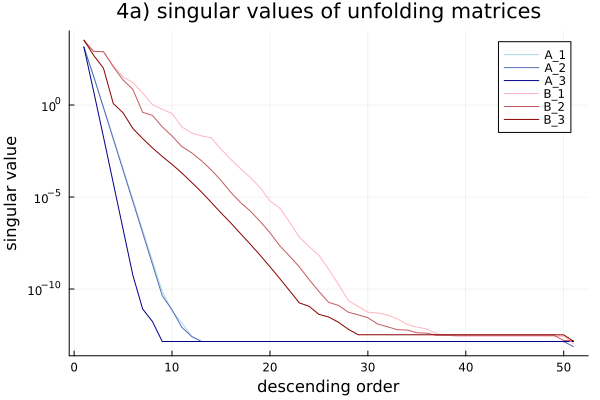

In [10]:
plot([], [],
    label="",
    title="4a) singular values of unfolding matrices",
    xlabel="descending order",
    ylabel="singular value",
    yscale=:log10,
)

plot!(
    1:n,
    Σ_A,
    palette=palette(:blues, d-1)[[end,1:end-1...]],
    label=reshape(["A_$k" for k ∈ 1:d-1], 1, d-1),
)
    
plot!(
    1:n,
    Σ_B,
    yscale=:log10,
    palette=palette(:reds, d-1)[[end,1:end-1...]],
    label=reshape(["B_$k" for k ∈ 1:d-1], 1, d-1),
)

Consider the accuracy thresholds $\varepsilon_j = 10^{−j}$ with $j \in \{2, 4, \dots, 12\}$. For each $k$ and every $j$, find the smallest $r_{j_k}$ such that the $k$-th unfolding matrix can be approximated with rank $r_{k_j}$ and with _relative_ Frobenius-norm error not exceeding $\varepsilon_j$ and compute the respective relative approximation error $\varepsilon_{j_k}$ ($\varepsilon_{j_k} \le \varepsilon_j$ should therefore hold for all $k$ and $j$).

In a single plot for all $k \in \{1, \dots, d−1\}$, show the dependence of $r_{j_k}$ on $j = \log_{10} \varepsilon_j^{−1}$. 

Referring to your observations and to the definition of $f$ and $g$, qualitatively explain the dependence of $r_{j_k}$ on $j$ for every fixed $k$ and on $k$ for every fixed $j$.

In [11]:
js = 2:2:12
tols = exp10.(-1 .* js)
;

In [12]:
function unfoldingApprox(unfolds::Vector{<:Matrix{<:Number}}, tols::Vector{<:Real})
    l = length(unfolds)
    m = length(tols)
    ranks = Matrix{Int}(undef, l, m)
    errors = Matrix{Float64}(undef, l, m)
    for k ∈ 1:l
        Ck = unfolds[k]
        U, Σ, V = svd(Ck)
        for j ∈ 1:m
            for r ∈ 1:length(Σ)
                Ck_approx = U[:,1:r] * Diagonal(Σ[1:r]) * V[:,1:r]'
                error = norm(Ck_approx - Ck) / norm(Ck)
                if error <= tols[j]
                    ranks[k,j] = r
                    errors[k,j] = error
                    break
                end
            end
        end
    end
    return ranks, errors
end
;

In [13]:
A_ranks, A_errors = unfoldingApprox(A_unfolded, tols)
B_ranks, B_errors = unfoldingApprox(B_unfolded, tols)
;

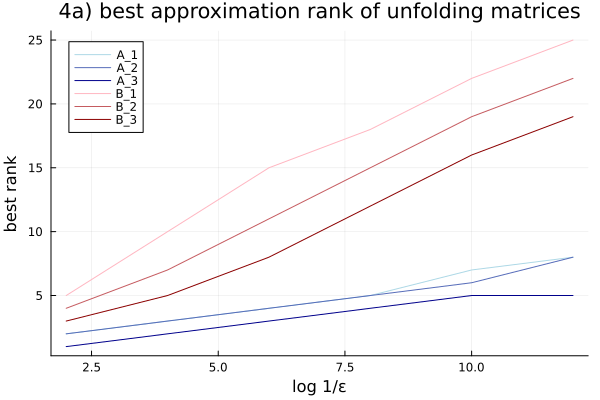

In [14]:
plot([], [],
    label="",
    title="4a) best approximation rank of unfolding matrices",
    xlabel="log 1/ε",
    ylabel="best rank",
)

plot!(
    js,
    [A_ranks[k,:] for k ∈ 1:d-1],
    palette=palette(:blues, d-1)[[end,1:end-1...]],
    label=reshape(["A_$k" for k ∈ 1:d-1], 1, d-1),
)

plot!(
    js,
    [B_ranks[k,:] for k ∈ 1:d-1],
    palette=palette(:reds, d-1)[[end,1:end-1...]],
    label=reshape(["B_$k" for k ∈ 1:d-1], 1, d-1),
)

#### b)

For each $j$, use your implementation of the Schmidt decomposition to compute an approximate MPS-TT representation of $C$ with ranks $r_1, \dots, r_{d−1}$ and compute the number $N_j$ of the parameters of the output decomposition (the total number of entries of all factors). Form the respective approximation $\hat{C}$ to $C$ by evaluating the decomposition and compute the relative error $\hat{\varepsilon}_j = \frac{\| \hat{C} - C \|_F}{\| C \|_F}$.

Check that this error does not exceed $\sqrt{\sum_{k=1}^{d-1} \varepsilon_{j_k}^2}$ and therefore agrees with the error analysis developed in the lectures.

In [15]:
function MPSTTapprox(C::Array{<:Number}, ranks::Matrix{<:Integer}, tols::Vector{<:Real})
    params = Vector{Int}(undef, length(tols))
    errors = Vector{Float64}(undef, length(tols))
    sigmas = Vector{Vector{Vector{Float64}}}(undef, length(tols))
    for j ∈ 1:length(tols)
        factors, sigmas[j], = TTSVD(C, ranks[:,j])
        C_hat = evalMPSTT(factors)
        params[j] = sum([prod(size(U)) for U ∈ factors])
        errors[j] = norm(C_hat - C) / norm(C)
    end
    return params, errors, sigmas
end
;

In [16]:
A_params, A_errors_hat, Σ_A_hat = MPSTTapprox(A, A_ranks, tols)
B_params, B_errors_hat, Σ_B_hat = MPSTTapprox(B, B_ranks, tols)
;

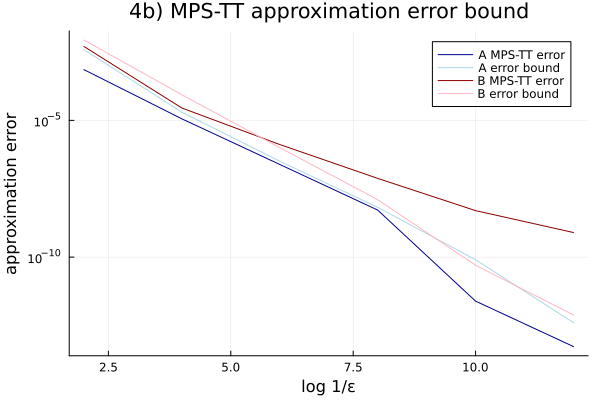

In [17]:
plot([], [],
    label="",
    yscale=:log10,
    title="4b) MPS-TT approximation error bound",
    xlabel="log 1/ε",
    ylabel="approximation error",
)

plot!(
    js,
    [A_errors_hat [sqrt(sum(A_errors[:,j] .^ 2)) for j ∈ 1:length(js)]],
    palette=palette(:blues, 2),
    label=["A MPS-TT error" "A error bound"],
)

plot!(
    js,
    [B_errors_hat [sqrt(sum(B_errors[:,j] .^ 2)) for j ∈ 1:length(js)]],
    palette=palette(:reds, 2),
    label=["B MPS-TT error" "B error bound"],
)

#### c)

For $j = 12$ and for every $k$, plot the dependence, on index $\alpha$, of **the ratios of** the $\alpha$-th singular value $\sigma^{\text{Schmidt}}_{k,\alpha}$ of the matrix that the Schmidt decomposition approximates at step $k$ (which were required above to be returned by the implementation) **to** the $\alpha$-th singular value $\sigma_{k,\alpha}$ of the $k$-th unfolding matrix of $C$. What relation do you observe? What part of the error analysis given in the lectures can be used to explain your observation and (in a couple of lines) how?

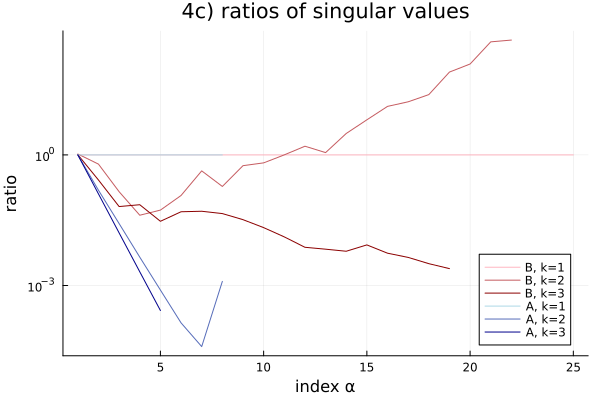

In [18]:
plot(
    [], [], label="",
    yscale=:log10,
    title="4c) ratios of singular values",
    xlabel="index α",
    ylabel="ratio",
    legend=:bottomright,
)

plot!(
    [1:length(σ_S) for σ_S ∈ Σ_B_hat[end]],
    [σ_S ./ σ_u[1:length(σ_S)] for (σ_u, σ_S) ∈ zip(Σ_B, Σ_B_hat[end])],
    palette=palette(:reds, d-1)[[end,1:end-1...]],
    label=reshape(["B, k=$k" for k ∈ 1:d-1], 1, d-1),
    )
    
plot!(
    [1:length(σ_S) for σ_S ∈ Σ_A_hat[end]],
    [σ_S ./ σ_u[1:length(σ_S)] for (σ_u, σ_S) ∈ zip(Σ_A, Σ_A_hat[end])],
    palette=palette(:blues, d-1)[[end,1:end-1...]],
    label=reshape(["A, k=$k" for k ∈ 1:d-1], 1, d-1),
)

#### d)

Plot the dependence of $N_j$ vs. $j = \log_{10} \varepsilon_j^{-1}$ in log-log scale. What asymptotic behavior do you observe and what convergence of the error with respect to the number of parameters does it suggest in general?

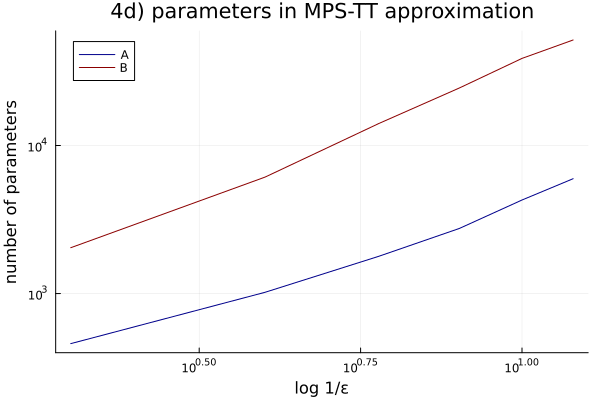

In [19]:
plot(
    js,
    [A_params B_params],
    xscale=:log10,
    yscale=:log10,
    palette=palette(:bluesreds, 2),
    label=["A" "B"],
    title="4d) parameters in MPS-TT approximation",
    xlabel="log 1/ε",
    ylabel="number of parameters",
)